In [118]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector, Parameter
from qiskit_algorithms.optimizers import COBYLA
import numpy as np
import math
import matplotlib.pyplot as plt

In [119]:
def create_unitary_evolution(num_address_qubits, num_embedding_qubits, evolution_indice=1):
    # Define quantum registers
    q_reg_address = QuantumRegister(num_address_qubits, name='q')
    q_reg_embedding = QuantumRegister(num_embedding_qubits, name='e')

    # Create a quantum circuit
    u1_qc = QuantumCircuit(q_reg_address, q_reg_embedding, name=str('U' + evolution_indice))

    # hadamat gate on all address qubits
    u1_qc.h(q_reg_address[:])
    # perform rotation on each address qubit with corresponding embedding qubit by theta
    for i in range(1):
        theta_params = [Parameter(f'theta_{evolution_indice}_{j}') for j in range(num_address_qubits)]
    
    for i in range(num_address_qubits - 1, -1, -1):
        u1_qc.cry(theta_params[i], i, num_address_qubits)
    # u1_qc.measure(q_reg_address[:], q_reg_embedding[:])
    
    # draw the custom circuit
    display(u1_qc.draw('mpl'))
    
    # return u1_qc.to_instruction()
    u_gate = u1_qc.to_gate()
    controlled_u_gate = u_gate.control(1)
    return controlled_u_gate

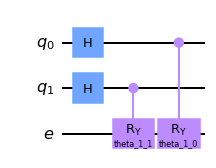

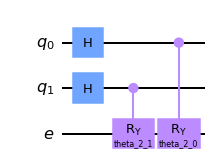

In [120]:
# Example 
num_ancilla_qubits = 1
num_address_qubits = 2
num_embedding_qubits = 1
u1_gate = create_unitary_evolution(num_address_qubits, num_embedding_qubits, '1')
u2_gate = create_unitary_evolution(num_address_qubits, num_embedding_qubits, '2')
# Display the circuit
# print(custom_gate)

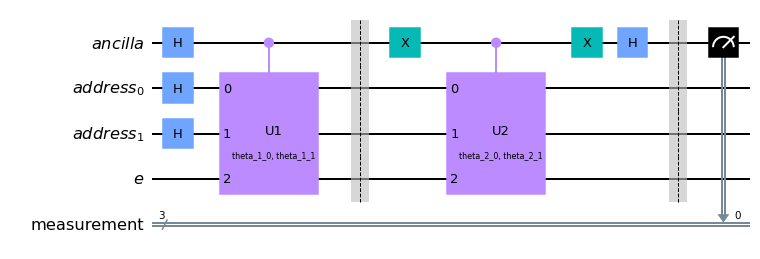

In [121]:
from qiskit.circuit.library import XGate  # Create QuantumRegisters
num_ancilla_qubits = 1
num_address_qubits = 2
num_embedding_qubits = 1
q_reg_ancilla = QuantumRegister(num_ancilla_qubits, name='ancilla')
q_reg_address = QuantumRegister(num_address_qubits, name='address')
q_reg_embedding = QuantumRegister(num_embedding_qubits, name='e')

# Create ClassicalRegister for measurement if needed
cr_measurement = ClassicalRegister(num_ancilla_qubits + num_address_qubits, name='measurement')

# Create QuantumCircuit
qc = QuantumCircuit(q_reg_ancilla, q_reg_address, q_reg_embedding, cr_measurement)

# Apply Hadamard gate to all ancilla qubits
qc.h(q_reg_ancilla[:])
qc.h(q_reg_address[:])

# cx gate between ancilla and all address qubits



# qc.cx(qreg_ancilla[:], q_reg_address[:] + q_reg_embedding[:])

# Append your custom u1 and u2 instructions to the circuit
qc.append(u1_gate, q_reg_ancilla[:] + q_reg_address[:] + q_reg_embedding[:])

# qc.ccx(qreg_ancilla[:], q_reg_address[:] + q_reg_embedding[:])

# anti_gate = XGate.control(ctrl_state='0', annotated='x')
# circuit.append(anti_gate, [qreg_ancilla[:], q_reg_address[:] + q_reg_embedding[:]])
qc.barrier()
# negative control workaround ? 
# x cx x
# qc.x(qreg_ancilla[:])
# qc.cx(qreg_ancilla[:], q_reg_address[:] + q_reg_embedding[:])
# qc.x(qreg_ancilla[:])
# qc.barrier()

qc.x(q_reg_ancilla[:])
qc.append(u2_gate, q_reg_ancilla[:] + q_reg_address[:] + q_reg_embedding[:])
qc.x(q_reg_ancilla[:])


qc.h(q_reg_ancilla[:])

qc.barrier()


qc.measure(q_reg_ancilla[:], cr_measurement[0])
# qc.measure(q_reg_address[:], cr_measurement[1:])

display(qc.draw('mpl'))

In [122]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator


In [123]:
def G_gate(alpha, beta, gamma):
    return np.array([
        [np.exp(1j*beta) * np.cos(alpha), np.exp(1j*gamma) * np.sin(alpha)],
        [-np.exp(-1j*gamma) * np.sin(alpha), np.exp(-1j*beta) * np.cos(alpha)]
    ])


In [124]:
def controlled_G_gate(alpha, beta, gamma):
    # Define the 4x4 matrix for the controlled G gate
    cg = np.eye(4, dtype=np.complex128)  # Start with an identity matrix
    g = G_gate(alpha, beta, gamma)
    cg[2:4, 2:4] = g  # Place the G gate in the bottom right corner for control on |1>
    return cg


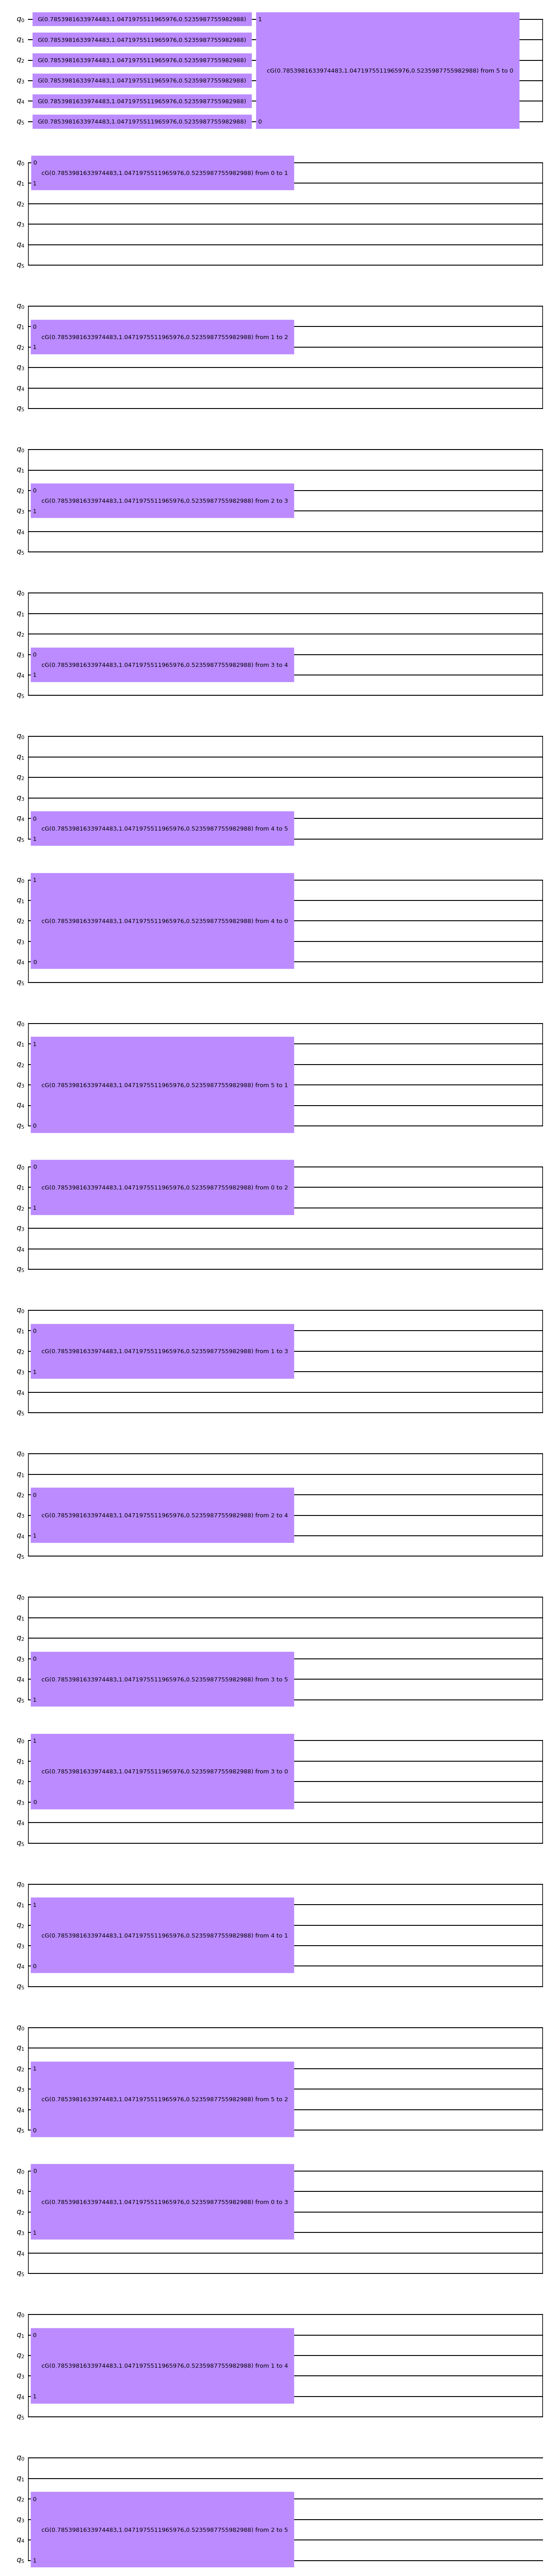

In [125]:
def create_unitary_circuit_subject_plus_predicate(params, label):
    n_qubits = 6  # Total number of qubits
    qc = QuantumCircuit(n_qubits, name=label)
    
    # Define the parameters for each G gate
    n = len(params) // 3
    gate_params = [params[3*i:3*(i+1)] for i in range(n)]

    # Apply a normal G gate to each qubit
    for i in range(n_qubits):
        alpha, beta, gamma = gate_params[i % n]  # Use modulo to cycle through params if not enough sets
        G = G_gate(alpha, beta, gamma)
        qc.unitary(Operator(G), [i], label=f'G({alpha},{beta},{gamma})')

    # Define the specific order of controlled gates, (controller, target) pairs
    controlled_gate_pairs = [
        (5, 0), (0, 1), (1, 2), (2, 3), (3, 4), (4, 5),  # Circular pattern
        (4, 0), (5, 1), (0, 2), (1, 3), (2, 4), (3, 5),  # Cross pattern
        (3, 0), (4, 1), (5, 2), (0, 3), (1, 4), (2, 5)   # Additional cross control gates
    ]

    # Apply controlled G gates in the specified order
    for idx, (ctrl, tgt) in enumerate(controlled_gate_pairs):
        alpha, beta, gamma = gate_params[idx % n]
        cG = controlled_G_gate(alpha, beta, gamma)
        qc.unitary(Operator(cG), [ctrl, tgt], label=f'cG({alpha},{beta},{gamma}) from {ctrl} to {tgt}')

    return qc




def create_unitary_circuit_object(params, label):
    n = len(params) // 3  # Number of G gates
    qc = QuantumCircuit(6, name=label)
    for i in range(n):
        alpha, beta, gamma = params[3*i], params[3*i+1], params[3*i+2]
        G = G_gate(alpha, beta, gamma)
        qc.unitary(Operator(G), [i], label=f'G({alpha},{beta},{gamma})')
    return qc

# Parameters for U1 and U2 - adjust as needed
params_u1 = [np.pi/2, np.pi/2, np.pi/2] * 24  # Repeat for the number of G gates in U1
params_u2 = [np.pi/2, np.pi/2, np.pi/2] * 6  # Repeat for the number of G gates in U2
u1 = create_unitary_circuit_subject_plus_predicate(params_u1, 'U1')
# print(u1)
display(u1.draw('mpl'))
u2 = create_unitary_circuit_object(params_u2, 'U2')


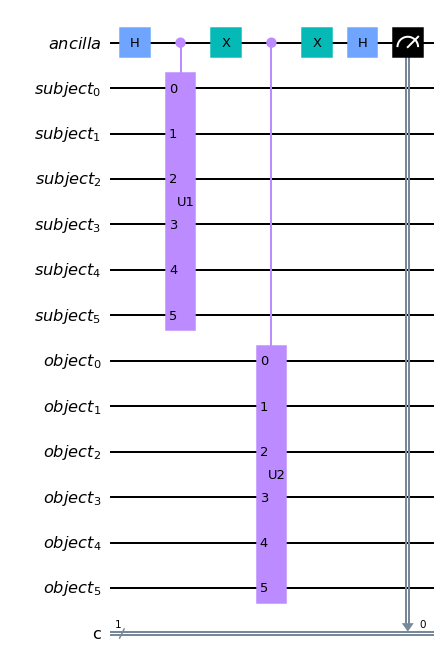

           ┌───┐       ┌───┐       ┌───┐┌───┐┌─┐
  ancilla: ┤ H ├───■───┤ X ├───■───┤ X ├┤ H ├┤M├
           └───┘┌──┴──┐└───┘   │   └───┘└───┘└╥┘
subject_0: ─────┤0    ├────────┼──────────────╫─
                │     │        │              ║ 
subject_1: ─────┤1    ├────────┼──────────────╫─
                │     │        │              ║ 
subject_2: ─────┤2    ├────────┼──────────────╫─
                │  U1 │        │              ║ 
subject_3: ─────┤3    ├────────┼──────────────╫─
                │     │        │              ║ 
subject_4: ─────┤4    ├────────┼──────────────╫─
                │     │        │              ║ 
subject_5: ─────┤5    ├────────┼──────────────╫─
                └─────┘     ┌──┴──┐           ║ 
 object_0: ─────────────────┤0    ├───────────╫─
                            │     │           ║ 
 object_1: ─────────────────┤1    ├───────────╫─
                            │     │           ║ 
 object_2: ─────────────────┤2    ├───────────╫─
                    

In [126]:
ancilla = QuantumRegister(1, 'ancilla')
subject = QuantumRegister(6, 'subject')
object_ = QuantumRegister(6, 'object')
creg = ClassicalRegister(1, 'c')
qc = QuantumCircuit(ancilla, subject, object_, creg)

# Prepare the ancilla in a superposition
qc.h(ancilla[0])

# Apply U1 controlled on the ancilla being |1>
qc.append(u1.to_gate().control(), [ancilla[0]] + subject[:])

# Reapply X-gate to flip ancilla back from |1> to |0>
qc.x(ancilla[0])

# Apply U2 controlled on the ancilla being |1>
qc.append(u2.to_gate().control(), [ancilla[0]] + object_[:])

qc.x(ancilla[0])


# Hadamard on the ancilla qubit to interfere the paths
qc.h(ancilla[0])

# Measure the ancilla qubit
qc.measure(ancilla[0], creg[0])

# Display the circuit
display(qc.draw('mpl'))
print(qc.draw())


In [127]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, simulator).result()
counts = result.get_counts()
print(counts)


{'0': 1}


In [ ]:
import numpy as np

def loss_function(y_true, y_pred, kappa):
    """
    Compute the custom loss function for the quantum circuit embedding model.
    
    Parameters:
    - y_true: array of true labels (numpy array)
    - y_pred: array of predicted labels from the quantum model (numpy array)
    - kappa: hyperparameter, positive integer
    
    Returns:
    - Loss value as a float
    """
    # Compute the loss component-wise
    loss = np.mean((y_true - y_pred) ** (2 * kappa))
    return loss


In [ ]:
def partial_derivative_loss(params, x_i, y_i, kappa, compute_eta):
    """
    Compute the partial derivatives of the loss function with respect to gate parameters.

    Parameters:
    - params: current parameters of the gates (dict with keys 'alpha', 'beta', 'gamma')
    - x_i: input feature for the ith sample
    - y_i: true label for the ith sample
    - kappa: hyperparameter
    - compute_eta: function to compute eta_QCE given parameters and input x_i

    Returns:
    - Dictionary of gradients {'d_alpha': value, 'd_beta': value, 'd_gamma': value}
    """
    eta_QCE = compute_eta(params, x_i)
    common_factor = 2 * kappa * (eta_QCE - y_i) ** (2 * kappa - 1)
    
    # Assuming you have the derivatives of G as defined in the section.
    # You would typically calculate these using the quantum circuit, here we show a placeholder
    gradients = {
        'd_alpha': common_factor * derivative_of_G(params, x_i, 'alpha'),
        'd_beta': common_factor * derivative_of_G(params, x_i, 'beta'),
        'd_gamma': common_factor * derivative_of_G(params, x_i, 'gamma')
    }
    return gradients


In [ ]:
def update_parameters(params, gradients, learning_rate):
    """
    Update the parameters using gradient descent.

    Parameters:
    - params: current gate parameters
    - gradients: computed gradients
    - learning_rate: step size in gradient descent

    Returns:
    - Updated parameters
    """
    params['alpha'] -= learning_rate * gradients['d_alpha']
    params['beta'] -= learning_rate * gradients['d_beta']
    params['gamma'] -= learning_rate * gradients['d_gamma']
    return params


In [ ]:
def measure_ancilla(qc):
    # Assuming the ancilla qubit is the last qubit in the circuit
    ancilla_index = qc.num_qubits - 1
    qc.measure_all()
    
    # Execute the circuit on a simulator
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend=simulator, shots=1024).result()
    counts = result.get_counts(qc)
    
    # Calculate the probabilities
    prob_0 = counts.get('0', 0) / 1024
    prob_1 = counts.get('1', 0) / 1024
    
    return prob_0, prob_1

def compute_eta_spo(qc):
    prob_0, prob_1 = measure_ancilla(qc)
    eta_spo = 2 * prob_0 - 1
    return eta_spo
